Name: Stephen Lacey

Student ID: 21165335

## Task 2

    Replicate the classifier training and evaluation demonstrated in the example notebook Lab 4 - Comparison of Binary Classifiers.ipynb but with the dataset seeds.csv. You will need to formulate a binary classification problem and transform the type column accordingly. Summarise your conclusions (max 200 words in a markdown cell).  


In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_recall_fscore_support
#from scipy import interp
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score

In [2]:
df = pd.read_csv("./seeds.csv")
data = np.array(df.values, dtype=float)
print('(number of examples, number of attributes): ', data.shape)

(number of examples, number of attributes):  (210, 8)


## Look at the data

In [3]:
## We want all numeric data
df.describe()

area   perimeter  compactness  length of kernel  width of kernel  \
count  210.000000  210.000000   210.000000        210.000000       210.000000   
mean    14.847524   14.559286     0.870999          5.628533         3.258605   
std      2.909699    1.305959     0.023629          0.443063         0.377714   
min     10.590000   12.410000     0.808100          4.899000         2.630000   
25%     12.270000   13.450000     0.856900          5.262250         2.944000   
50%     14.355000   14.320000     0.873450          5.523500         3.237000   
75%     17.305000   15.715000     0.887775          5.979750         3.561750   
max     21.180000   17.250000     0.918300          6.675000         4.033000   

       asymmetry coefficient  length of kernel groove        type  
count             210.000000               210.000000  210.000000  
mean                3.700201                 5.408071    2.000000  
std                 1.503557                 0.491480    0.818448  
min                 0.765100                 4.519000    1.000000  
25%                 2.561500                 5.045000    1.000000  
50%                 3.599000                 5.223000    2.000000  
75%                 4.768750                 5.877000    3.000000  
max                 8.456000                 6.550000    3.000000

In [4]:
df.head()

area  perimeter  compactness  length of kernel  width of kernel  \
0  15.26      14.84       0.8710             5.763            3.312   
1  14.88      14.57       0.8811             5.554            3.333   
2  14.29      14.09       0.9050             5.291            3.337   
3  13.84      13.94       0.8955             5.324            3.379   
4  16.14      14.99       0.9034             5.658            3.562   

   asymmetry coefficient  length of kernel groove  type  
0                  2.221                    5.220     1  
1                  1.018                    4.956     1  
2                  2.699                    4.825     1  
3                  2.259                    4.805     1  
4                  1.355                    5.175     1

In [5]:
df.tail()

area  perimeter  compactness  length of kernel  width of kernel  \
205  12.19      13.20       0.8783             5.137            2.981   
206  11.23      12.88       0.8511             5.140            2.795   
207  13.20      13.66       0.8883             5.236            3.232   
208  11.84      13.21       0.8521             5.175            2.836   
209  12.30      13.34       0.8684             5.243            2.974   

     asymmetry coefficient  length of kernel groove  type  
205                  3.631                    4.870     3  
206                  4.325                    5.003     3  
207                  8.315                    5.056     3  
208                  3.598                    5.044     3  
209                  5.637                    5.063     3

In [6]:
df['type'].value_counts()

1    70
2    70
3    70
Name: type, dtype: int64

#### Explore the data for type and outliers

In [7]:
# We don't want nulls/NaNs in the dataset
df.isna().sum()

area                       0
perimeter                  0
compactness                0
length of kernel           0
width of kernel            0
asymmetry coefficient      0
length of kernel groove    0
type                       0
dtype: int64

OK - the data is all numeric and no nulls are present, so next we need to...

Check the boxplots of the numerical columns for outliers. We will do this in three slices

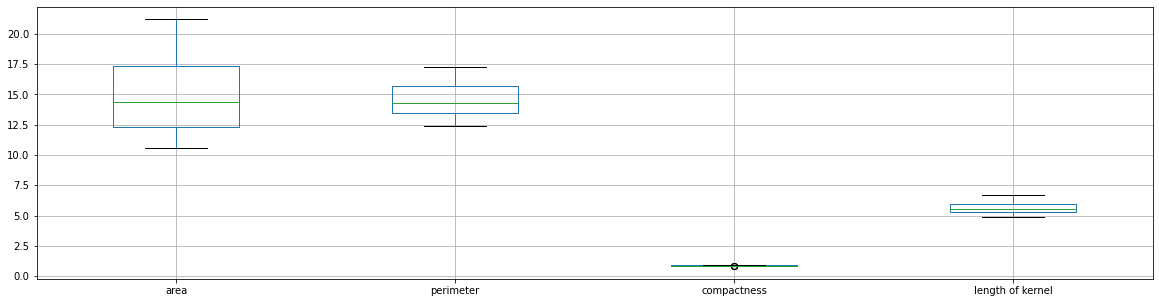

In [8]:
df.loc[:,'area':'length of kernel'].boxplot(figsize=(20,5))
plt.show()

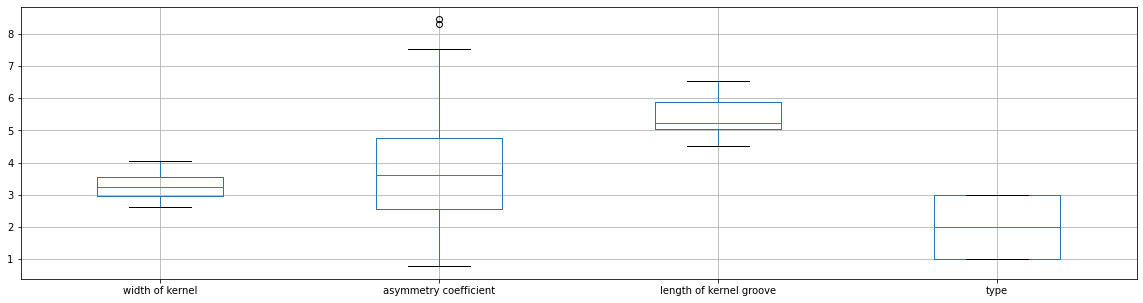

In [9]:
df.loc[:,'width of kernel':'type'].boxplot(figsize=(20,5))
plt.show()

#### Doesn't look like there are significant outliers, maybe a few in "asymmetry coefficient" and "compactness"

#### Next, let us look at the data distributions too.

array([[<AxesSubplot:title={'center':'area'}>,
        <AxesSubplot:title={'center':'perimeter'}>],
       [<AxesSubplot:title={'center':'compactness'}>,
        <AxesSubplot:title={'center':'length of kernel'}>]], dtype=object)

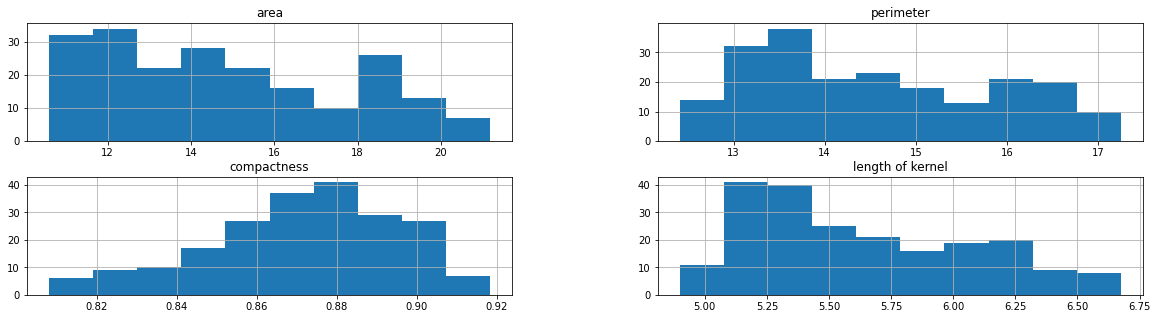

In [10]:
df.loc[:,'area':'length of kernel'].hist(figsize=(20,5))

#### Let us look at the rest of the distributions now

array([[<AxesSubplot:title={'center':'width of kernel'}>,
        <AxesSubplot:title={'center':'asymmetry coefficient'}>],
       [<AxesSubplot:title={'center':'length of kernel groove'}>,
        <AxesSubplot:title={'center':'type'}>]], dtype=object)

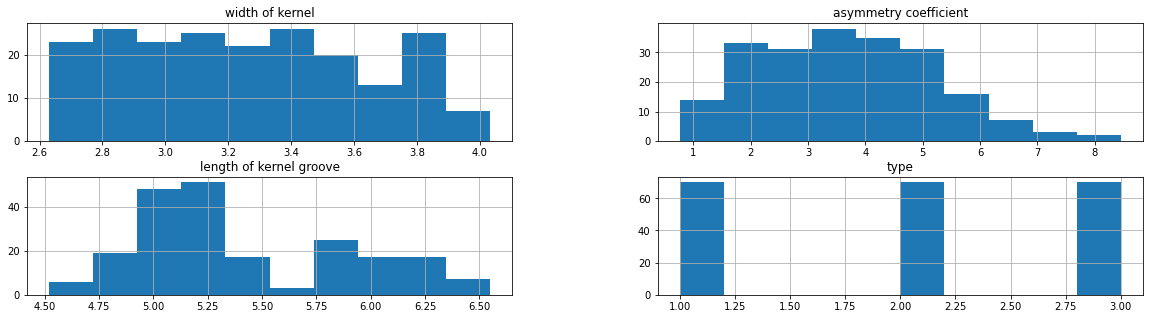

In [11]:
df.loc[:,'width of kernel':'type'].hist(figsize=(20,5))

### Looks like some of these histograms could benefit from being made more gaussian

#### Plot what they look like when transformed by log and sqrt transformations

Plots with dists before and after change for area


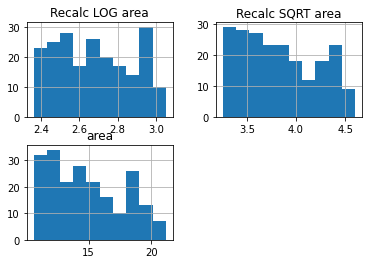

Plots with dists before and after change for perimeter


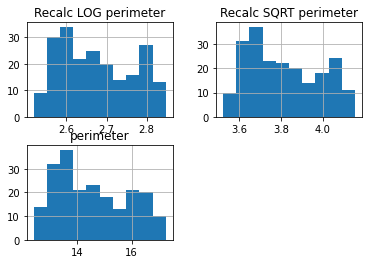

Plots with dists before and after change for compactness


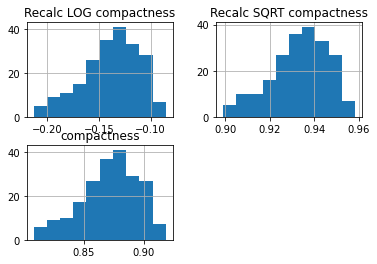

Plots with dists before and after change for length of kernel


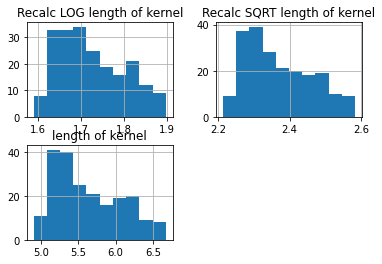

Plots with dists before and after change for width of kernel


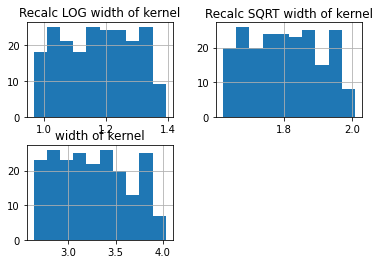

Plots with dists before and after change for asymmetry coefficient


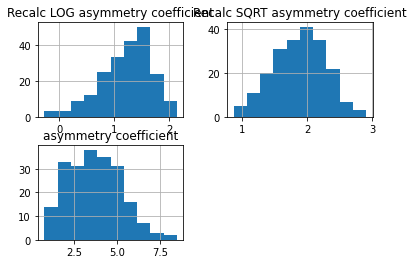

Plots with dists before and after change for length of kernel groove


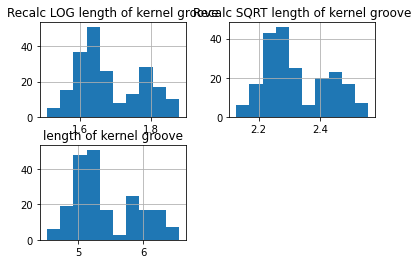

Plots with dists before and after change for type


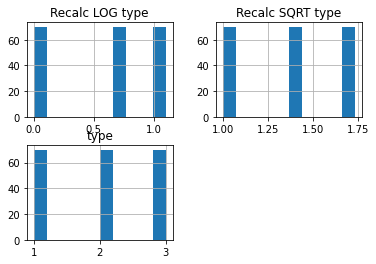

In [12]:
### Create a copy of the dataframe
df_adj = df.copy(deep=True)

i = 0
### Loop through the columns
for c in df_adj:
    min_val=df_adj[c].min()

    if min_val<0:
        min_val = abs(min_val) +1
    else:
        min_val=0

    ### Create 2 new "recalc" columns
    col1 = "Recalc LOG " + c
    df_adj[col1]=np.log(df_adj[c]+(min_val))
    col2 = "Recalc SQRT " + c
    df_adj[col2]=np.sqrt(df_adj[c]+(min_val))
    i += 1

    ### Plot before and after distributions
    print("Plots with dists before and after change for {0}".format(c))
    df_adj.hist(column=[col1, col2, c ])
    plt.show()    


#### What does the "Assymetary coefficient" look like log transformed?

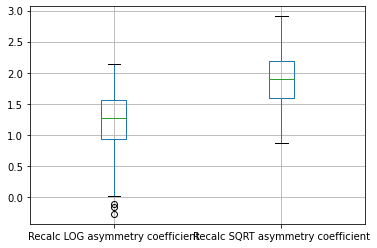

In [13]:
df_adj.boxplot(column=["Recalc LOG asymmetry coefficient","Recalc SQRT asymmetry coefficient"])
plt.show()

#### And what does compactness look like?

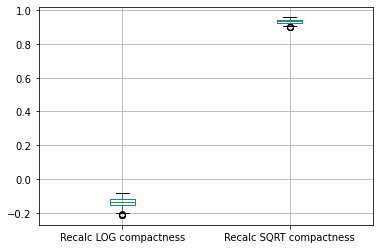

In [14]:
df_adj.boxplot(column=["Recalc LOG compactness", "Recalc SQRT compactness"])
plt.show()

#### Outliers Conclusion:


The `asymmetry coefficient` column appears to have minor outliers which are removed by SQRT transform.  
I will apply this transform and the `StandardScaler` to this field.  

The `compactness` column appears to have minor outliers I will apply the log transform and the `RobustScaler` to this.  

The rest I will just apply `StandardScaler`.

## Target Classification Column: Data Preparation

First, we transform the `type` column to binary.

In [15]:
## Map Types. We're going to imagine type 3 is False (0) and Type 1 and type 2 are True (1)
mapper = {1: 1, 2: 1, 3: 0}
df['type'] = df['type'].replace(mapper)
df['type'].value_counts()

1    140
0     70
Name: type, dtype: int64

## Classification

We will attempt training SVM and Random Forest classifiers.  

First, we need to prepare lists of column names (4 in this case). 
 * The list `names_all` contains all column headers
 * The list `names_outliers` contains the name of the column to which we will apply log transformation followed by RobustScaler. 
 * The `names_sqrt_transform` contains the name of the column to which we will apply sqrt transformation, then StandardScaler 
 * The list `names_rest` contains the names of all other predictor columns to which we will apply StandardScaler.


In [16]:
# store a list with the names of all predictors
names_all = [c for c in df if c not in ['type']]

# define column groups with same data preparation - these columns need to be log transformed and then RobustScaled
names_outliers = ['compactness']

# define column groups with same data preparation - these columns need to be sqrt transformed and then StandardScaled
names_sqrt_transform = ['asymmetry coefficient']
names_rest = list(set(names_all) - set(names_outliers) - set(names_sqrt_transform) )

In [17]:
class AddColumnNames(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return pd.DataFrame(data=X, columns=self.columns)

Then we need another class to be able to select a particular group of columns.


In [18]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X[self.columns]

In [19]:
preprocess_pipeline = make_pipeline(
    AddColumnNames(columns=names_all),
    FeatureUnion(transformer_list=[
        ("names_outliers", make_pipeline(
            ColumnSelector(columns=names_outliers),
            FunctionTransformer(np.log, validate=True),
            RobustScaler()
        )),
        ("names_sqrt_transform", make_pipeline(
            ColumnSelector(columns=names_sqrt_transform),
            FunctionTransformer(np.sqrt, validate=True),
            StandardScaler()
        )),        
        ("names_rest", make_pipeline(
            ColumnSelector(columns=names_rest),
            StandardScaler()
        ))
    ])
)

Now we can separate the columns into *target* and *predictors* and split the dataset into a training and test sets.

In [20]:
y = df['type']
X = df.drop('type', axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

## Grid Search for Best Parameters of Classifiers


In [21]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('svm', svm.SVC(probability=True))])

# prepare a prameter grid
# note that __ can be used to specify the name of a parameter for a specific element in a pipeline
param_grid = {
    'svm__C': [0.001, 0.1, 1, 5, 10, 50, 100],  
    'svm__gamma': [3, 2, 1, 0.1, 0.01, 0.001], 
    'svm__kernel': ['rbf', 'linear', 'poly'],
    'svm__degree': [2,3]}

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train) #trainign happens here! SVM is trained 240 times
#Julia

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
SVM_best_params = search.best_params_
SVM_best_model = search.best_estimator_

Best CV score = 0.982:
Best parameters:  {'svm__C': 100, 'svm__degree': 2, 'svm__gamma': 3, 'svm__kernel': 'linear'}


#### Now for Random Forest

In [22]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('rf', RandomForestClassifier())])

# prepare a prameter grid
# note that __ can be used to specify the name of a parameter for a specific element in a pipeline
param_grid = {
    'rf__n_estimators' : [1, 3, 5, 7, 10,20,30,50,100],
    'rf__max_depth': [2,3, 4, 5, 6,7, 8,9, 10,11, 12],
    'rf__criterion' : ['gini', 'entropy'],
    'rf__min_samples_leaf' : [1,2,3] 
}

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.976:
Best parameters:  {'rf__criterion': 'entropy', 'rf__max_depth': 8, 'rf__min_samples_leaf': 3, 'rf__n_estimators': 5}


## Compare Classifiers on Test Set


In [23]:
mean_fpr = np.linspace(start=0, stop=1, num=100)

In [24]:
# model - a trained binary probabilistic classification model;
#         it is assumed that there are two classes: 0 and 1
#         and the classifier learns to predict probabilities for the examples to belong to class 1

def evaluate_model(X_test, y_test, model):
    # compute probabilistic predictiond for the evaluation set
    _probabilities = model.predict_proba(X_test)[:, 1]
    
    # compute exact predictiond for the evaluation set
    _predicted_values = model.predict(X_test)
        
    # compute accuracy
    _accuracy = accuracy_score(y_test, _predicted_values)
        
    # compute precision, recall and f1 score for class 1
    _precision, _recall, _f1_score, _ = precision_recall_fscore_support(y_test, _predicted_values, labels=[1])
    # compute precision recall and corresponding accuracy
    _pr_precision, _pr_recall, _ = precision_recall_curve(y_test, _probabilities)
    _pr_f1, _pr_auc = f1_score(y_test, _predicted_values), auc(_pr_recall, _pr_precision)
    
    # compute fpr and tpr values for various thresholds 
    # by comparing the true target values to the predicted probabilities for class 1
    _fpr, _tpr, _ = roc_curve(y_test, _probabilities)
        
    # compute true positive rates for the values in the array mean_fpr
    _tpr_transformed = np.array([np.interp(mean_fpr, _fpr, _tpr)])
    
    # compute the area under the curve
    _auc = auc(_fpr, _tpr)
            
    return _accuracy, _precision[0], _recall[0], _f1_score[0], _tpr_transformed, _auc, _pr_precision, _pr_recall, _pr_f1, _pr_auc

Now we will use the function above to evaluate the best SVM and Random Forest models found by the grid search.

In [25]:
SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score, SVM_tpr, SVM_auc, SVM_pr_precision, SVM_pr_recall, SVM_pr_f1, SVM_pr_auc = evaluate_model(X_test, y_test, SVM_best_model)
RF_accuracy, RF_precision, RF_recall, RF_f1_score, RF_tpr, RF_auc, RF_pr_precision, RF_pr_recall, RF_pr_f1, RF_pr_auc = evaluate_model(X_test, y_test, RF_best_model)

#### Examine accuracies of both models as well as their precision, recall and F1-score for class 1. 

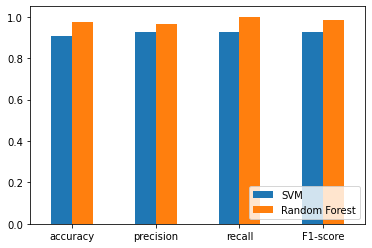

In [26]:
SVM_metrics = np.array([SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score])
RF_metrics = np.array([RF_accuracy, RF_precision, RF_recall, RF_f1_score])
index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'SVM': SVM_metrics, 'Random Forest': RF_metrics}, index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.show()

Both classifiers perform well with Random Forest being slightly better. Most important, both have high recall for class 1, which is what we were looking for.

We can also examine the ROC and PR curves of the two classifiers for class 1.

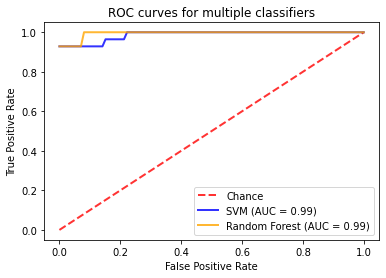

In [27]:
#### Plot the ROC Curves
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
plt.plot(mean_fpr, SVM_tpr[0,:], lw=2, color='blue', label='SVM (AUC = %0.2f)' % (SVM_auc), alpha=0.8)
plt.plot(mean_fpr, RF_tpr[0,:], lw=2, color='orange', label='Random Forest (AUC = %0.2f)' % (RF_auc), alpha=0.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for multiple classifiers')
plt.legend(loc="lower right")
plt.show()

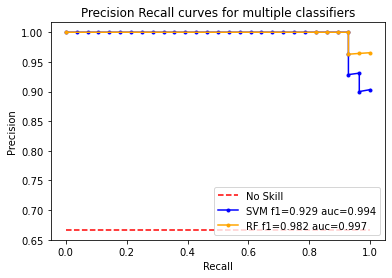

In [28]:
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', color='red', label='No Skill')
plt.plot(SVM_pr_recall, SVM_pr_precision, marker='.', color='blue', label='SVM f1=%.3f auc=%.3f' % (SVM_pr_f1, SVM_pr_auc))
plt.plot(RF_pr_recall, RF_pr_precision, marker='.', color='orange', label='RF f1=%.3f auc=%.3f' % (RF_pr_f1, RF_pr_auc))
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.title('Precision Recall curves for multiple classifiers')
plt.legend(loc="lower right")
# show the plot
plt.show()

## TASK 2 CONCLUSION 

The binary classification I set up was a simple split of the `type` from 3 classes to 2. I set Type 3 to False (0) and Type 1 and Type 2 to True (1). The `Type` column is then remapped such that it has 70 *False* values and 140 *True*.  

After training the 2 classifiers, I can see that both perform very well on the data provided.  

The ROC curve shows that both classifiers perform very well, with SVM slightly outperforming Random Forest. The corresponding AUC ROC for both classifiers is extremely high, with SVM slightly ahead as expected from the ROC curve.  

**HOWEVER**, ROC curves should be used when there are roughly equal numbers of observations for each class. Precision-Recall (PR) curves should be used when there is a moderate to large class imbalance.
In our case there are 66% True and 33% False, so the data is imbalanced.  

Based on this I also graphed the PR Curve which shows the SVM performs better than RF. Additionally the RF PR values drop dramatically toward the end of the graph.  

I can conclude that both classifiers do a good job on this dataset and SVM outperforms Random Forest.  

# Task 3

Train a third classifier (e.g., MLPClassifier, Naive Bayes, kNN) with seeds.csv add compare it to both SVM and Random Forest. 

For this task I will add the KNNClassifier. I will follow the same hyperparameter grid search as before to the classifier has the best chance of working with the appropriate parameters

In [29]:
from sklearn.neighbors import KNeighborsClassifier

# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('knn', KNeighborsClassifier())])

# prepare a prameter grid
# note that __ can be used to specify the name of a parameter for a specific element in a pipeline
param_grid = {
    'knn__n_neighbors' : list(range(1, 31)),
    'knn__weights': ['uniform', 'distance'],
    'knn__algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
}

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
KNN_best_params = search.best_params_
KNN_best_model = search.best_estimator_

Best CV score = 0.964:
Best parameters:  {'knn__algorithm': 'auto', 'knn__n_neighbors': 6, 'knn__weights': 'distance'}


As before, evaluate the model and save the results

In [30]:
KNN_accuracy, KNN_precision, KNN_recall, KNN_f1_score, KNN_tpr, KNN_auc, KNN_pr_precision, KNN_pr_recall, KNN_pr_f1, KNN_pr_auc = evaluate_model(X_test, y_test, KNN_best_model)

Add an entry for KNN Metrics and graph alongside the SVM and Random Forest

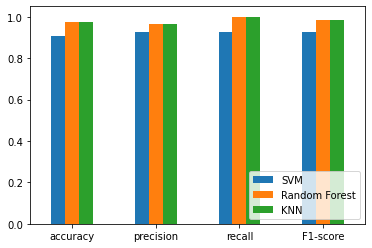

In [31]:
KNN_metrics = np.array([KNN_accuracy, KNN_precision, KNN_recall, KNN_f1_score])
index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'SVM': SVM_metrics, 'Random Forest': RF_metrics, 'KNN': KNN_metrics}, index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.show()

All classifiers perform well with Random Forest and KNN performing in a very similar manner. Most important, all have high recall for class 1, which is what we were looking for. 

#### Plot the ROC Curves

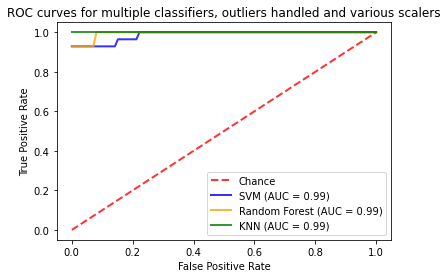

In [32]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
plt.plot(mean_fpr, SVM_tpr[0,:], lw=2, color='blue', label='SVM (AUC = %0.2f)' % (SVM_auc), alpha=0.8)
plt.plot(mean_fpr, RF_tpr[0,:], lw=2, color='orange', label='Random Forest (AUC = %0.2f)' % (RF_auc), alpha=0.8)
plt.plot(mean_fpr, KNN_tpr[0,:], lw=2, color='green', label='KNN (AUC = %0.2f)' % (RF_auc), alpha=0.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for multiple classifiers, outliers handled and various scalers')
plt.legend(loc="lower right")
plt.show()

#### Plot the precision-recall curves

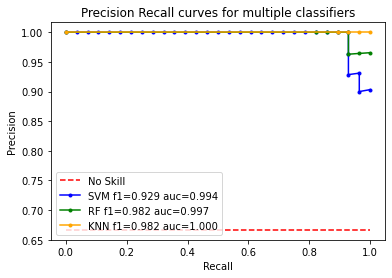

In [33]:
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', color='red', label='No Skill')
plt.plot(SVM_pr_recall, SVM_pr_precision, marker='.', color='blue', label='SVM f1=%.3f auc=%.3f' % (SVM_pr_f1, SVM_pr_auc))
plt.plot(RF_pr_recall, RF_pr_precision, marker='.', color='green', label='RF f1=%.3f auc=%.3f' % (RF_pr_f1, RF_pr_auc))
plt.plot(KNN_pr_recall, KNN_pr_precision, marker='.', color='orange', label='KNN f1=%.3f auc=%.3f' % (KNN_pr_f1, KNN_pr_auc))
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.title('Precision Recall curves for multiple classifiers')
plt.legend(loc="lower left")
# show the plot
plt.show()

In [34]:
df_metrics.head()

SVM  Random Forest       KNN
accuracy   0.904762       0.976190  0.976190
precision  0.928571       0.965517  0.965517
recall     0.928571       1.000000  1.000000
F1-score   0.928571       0.982456  0.982456

# Alternative approaches to handing the data in the pipeline


### Now, alter the pipeline and handle data differently

#### Just apply the log transform to 1 column and SQRT the other, only use Standard scaler...See if we get better results

The "_no" below refers to No RobustScaler For Outliers

In [35]:
df = pd.read_csv("./seeds.csv")

# store a list with the names of all predictors
names_all = [c for c in df if c not in ['type']]

# define column groups with same data preparation - these columns need to be log transformed and then StandardScaled
names_log_transform = ['compactness']
names_sqrt_transform = ['asymmetry coefficient']
names_rest = list(set(names_all)  - set(names_log_transform) - set(names_sqrt_transform) )

preprocess_pipeline = make_pipeline(
    AddColumnNames(columns=names_all),
    FeatureUnion(transformer_list=[
        ("names_log_transform", make_pipeline(
            ColumnSelector(columns=names_log_transform),
            FunctionTransformer(np.log, validate=True),
            StandardScaler()
        )),
        ("names_sqrt_transform", make_pipeline(
            ColumnSelector(columns=names_log_transform),
            FunctionTransformer(np.sqrt, validate=True),
            StandardScaler()
        )),
        ("names_rest", make_pipeline(
            ColumnSelector(columns=names_rest),
            StandardScaler()
        ))
    ])
)

# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('svm', svm.SVC(probability=True))])

# prepare a prameter grid
# note that __ can be used to specify the name of a parameter for a specific element in a pipeline
param_grid = {
    'svm__C': [0.001, 0.1, 1, 5, 10, 50, 100],  
    'svm__gamma': [3, 2, 1, 0.1, 0.01, 0.001], 
    'svm__kernel': ['rbf', 'linear', 'poly'],
    'svm__degree': [2,3]}

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train) #trainign happens here! SVM is trained 240 times
#Julia

print("SVM Best CV score = %0.3f:" % search.best_score_)
print("SVM Best parameters: ", search.best_params_)

# store the best params and best model for later use
SVM_best_params_no = search.best_params_
SVM_best_model_no = search.best_estimator_

# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('rf', RandomForestClassifier())])

# prepare a prameter grid
# note that __ can be used to specify the name of a parameter for a specific element in a pipeline
param_grid = {
    'rf__n_estimators' : [1, 3, 5, 7, 10,20,30,50,100],
    'rf__max_depth': [2,3, 4, 5, 6,7, 8,9, 10,11, 12],
    'rf__criterion' : ['gini', 'entropy'],
    'rf__min_samples_leaf' : [1,2,3] 
}

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("RF Best CV score = %0.3f:" % search.best_score_)
print("RF Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params_no = search.best_params_
RF_best_model_no = search.best_estimator_

from sklearn.neighbors import KNeighborsClassifier

# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('knn', KNeighborsClassifier())])

# prepare a prameter grid
# note that __ can be used to specify the name of a parameter for a specific element in a pipeline
param_grid = {
    'knn__n_neighbors' : list(range(1, 31)),
    'knn__weights': ['uniform', 'distance'],
    'knn__algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
}

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("KNN Best CV score = %0.3f:" % search.best_score_)
print("KNN Best parameters: ", search.best_params_)

# store the best params and best model for later use
KNN_best_params_no = search.best_params_
KNN_best_model_no = search.best_estimator_

SVM_accuracy_no, SVM_precision_no, SVM_recall_no, SVM_f1_score_no, SVM_tpr_no, SVM_auc_no, SVM_pr_precision_no, SVM_pr_recall_no, SVM_pr_f1_no, SVM_pr_auc_no = evaluate_model(X_test, y_test, SVM_best_model_no)
RF_accuracy_no, RF_precision_no, RF_recall_no, RF_f1_score_no, RF_tpr_no, RF_auc_no, RF_pr_precision_no, RF_pr_recall_no, RF_pr_f1_no, RF_pr_auc_no = evaluate_model(X_test, y_test, RF_best_model_no)
KNN_accuracy_no, KNN_precision_no, KNN_recall_no, KNN_f1_score_no, KNN_tpr_no, KNN_auc_no, KNN_pr_precision_no, KNN_pr_recall_no, KNN_pr_f1_no, KNN_pr_auc_no = evaluate_model(X_test, y_test, KNN_best_model_no)

SVM Best CV score = 0.964:
SVM Best parameters:  {'svm__C': 10, 'svm__degree': 2, 'svm__gamma': 1, 'svm__kernel': 'rbf'}
RF Best CV score = 0.953:
RF Best parameters:  {'rf__criterion': 'entropy', 'rf__max_depth': 10, 'rf__min_samples_leaf': 1, 'rf__n_estimators': 5}
KNN Best CV score = 0.952:
KNN Best parameters:  {'knn__algorithm': 'auto', 'knn__n_neighbors': 15, 'knn__weights': 'distance'}


### Plot the results of the new pipeline against the old one

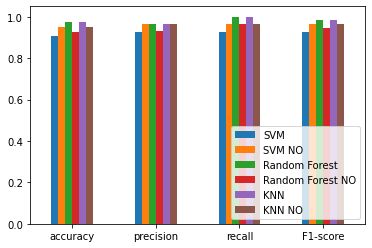

In [36]:
SVM_metrics_no = np.array([SVM_accuracy_no, SVM_precision_no, SVM_recall_no, SVM_f1_score_no])
RF_metrics_no = np.array([RF_accuracy_no, RF_precision_no, RF_recall_no, RF_f1_score_no])
KNN_metrics_no = np.array([KNN_accuracy_no, KNN_precision_no, KNN_recall_no, KNN_f1_score_no])
index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'SVM': SVM_metrics, 'SVM NO': SVM_metrics_no, 'Random Forest': RF_metrics, 'Random Forest NO': RF_metrics_no, 'KNN': KNN_metrics, 'KNN NO': KNN_metrics_no}, index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.show()

## Plot the ROC curves for the new pipeline

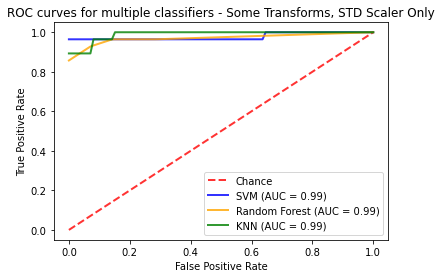

In [46]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
plt.plot(mean_fpr, SVM_tpr_no[0,:], lw=2, color='blue', label='SVM (AUC = %0.2f)' % (SVM_auc), alpha=0.8)
plt.plot(mean_fpr, RF_tpr_no[0,:], lw=2, color='orange', label='Random Forest (AUC = %0.2f)' % (RF_auc), alpha=0.8)
plt.plot(mean_fpr, KNN_tpr_no[0,:], lw=2, color='green', label='KNN (AUC = %0.2f)' % (RF_auc), alpha=0.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for multiple classifiers - Some Transforms, STD Scaler Only')
plt.legend(loc="lower right")
plt.show()

## Plot the Precision Recall curves for the new pipeline

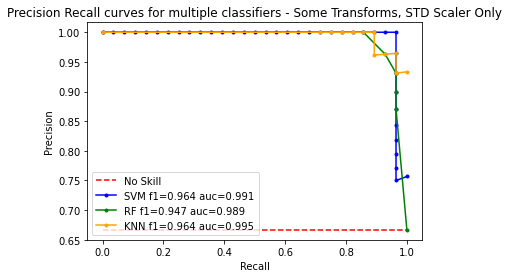

In [47]:
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', color='red', label='No Skill')
plt.plot(SVM_pr_recall_no, SVM_pr_precision_no, marker='.', color='blue', label='SVM f1=%.3f auc=%.3f' % (SVM_pr_f1_no, SVM_pr_auc_no))
plt.plot(RF_pr_recall_no, RF_pr_precision_no, marker='.', color='green', label='RF f1=%.3f auc=%.3f' % (RF_pr_f1_no, RF_pr_auc_no))
plt.plot(KNN_pr_recall_no, KNN_pr_precision_no, marker='.', color='orange', label='KNN f1=%.3f auc=%.3f' % (KNN_pr_f1_no, KNN_pr_auc_no))
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.title('Precision Recall curves for multiple classifiers - Some Transforms, STD Scaler Only')
plt.legend(loc="lower left")
# show the plot
plt.show()

#### Removing Robust Scaler improves SVM. 


### Now, alter the pipeline and handle data differently again

#### Don't apply any log transforms only use Standard scaler...See if we get better results

The "_std" below refers to StdScaler only used

In [45]:
df = pd.read_csv("./seeds.csv")

# store a list with the names of all predictors
names_all = [c for c in df if c not in ['type']]

preprocess_pipeline = make_pipeline(
    AddColumnNames(columns=names_all),
    FeatureUnion(transformer_list=[
        ("names_all", make_pipeline(
            ColumnSelector(columns=names_all),
            StandardScaler()
        ))
    ])
)

# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('svm', svm.SVC(probability=True))])

# prepare a prameter grid
# note that __ can be used to specify the name of a parameter for a specific element in a pipeline
param_grid = {
    'svm__C': [0.001, 0.1, 1, 5, 10, 50, 100],  
    'svm__gamma': [3, 2, 1, 0.1, 0.01, 0.001], 
    'svm__kernel': ['rbf', 'linear', 'poly'],
    'svm__degree': [2,3]}

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train) #trainign happens here! SVM is trained 240 times
#Julia

print("SVM Best CV score = %0.3f:" % search.best_score_)
print("SVM Best parameters: ", search.best_params_)

# store the best params and best model for later use
SVM_best_params_std = search.best_params_
SVM_best_model_std = search.best_estimator_

# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('rf', RandomForestClassifier())])

# prepare a prameter grid
# note that __ can be used to specify the name of a parameter for a specific element in a pipeline
param_grid = {
    'rf__n_estimators' : [1, 3, 5, 7, 10,20,30,50,100],
    'rf__max_depth': [2,3, 4, 5, 6,7, 8,9, 10,11, 12],
    'rf__criterion' : ['gini', 'entropy'],
    'rf__min_samples_leaf' : [1,2,3] 
}

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("RF Best CV score = %0.3f:" % search.best_score_)
print("RF Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params_std = search.best_params_
RF_best_model_std = search.best_estimator_

from sklearn.neighbors import KNeighborsClassifier

# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('knn', KNeighborsClassifier())])

# prepare a prameter grid
# note that __ can be used to specify the name of a parameter for a specific element in a pipeline
param_grid = {
    'knn__n_neighbors' : list(range(1, 31)),
    'knn__weights': ['uniform', 'distance'],
    'knn__algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
}

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("KNN Best CV score = %0.3f:" % search.best_score_)
print("KNN Best parameters: ", search.best_params_)

# store the best params and best model for later use
KNN_best_params_std = search.best_params_
KNN_best_model_std = search.best_estimator_

SVM_accuracy_std, SVM_precision_std, SVM_recall_std, SVM_f1_score_std, SVM_tpr_std, SVM_auc_std, SVM_pr_precision_std, SVM_pr_recall_std, SVM_pr_f1_std, SVM_pr_auc_std = evaluate_model(X_test, y_test, SVM_best_model_std)
RF_accuracy_std, RF_precision_std, RF_recall_std, RF_f1_score_std, RF_tpr_std, RF_auc_std, RF_pr_precision_std, RF_pr_recall_std, RF_pr_f1_std, RF_pr_auc_std = evaluate_model(X_test, y_test, RF_best_model_std)
KNN_accuracy_std, KNN_precision_std, KNN_recall_std, KNN_f1_score_std, KNN_tpr_std, KNN_auc_std, KNN_pr_precision_std, KNN_pr_recall_std, KNN_pr_f1_std, KNN_pr_auc_std = evaluate_model(X_test, y_test, KNN_best_model_std)

C:\ProgramData\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


SVM Best CV score = 0.982:
SVM Best parameters:  {'svm__C': 100, 'svm__degree': 2, 'svm__gamma': 3, 'svm__kernel': 'linear'}
RF Best CV score = 0.970:
RF Best parameters:  {'rf__criterion': 'gini', 'rf__max_depth': 6, 'rf__min_samples_leaf': 2, 'rf__n_estimators': 20}
KNN Best CV score = 0.970:
KNN Best parameters:  {'knn__algorithm': 'auto', 'knn__n_neighbors': 10, 'knn__weights': 'distance'}


#### Graph the results against each other again

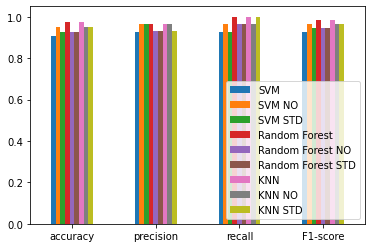

In [40]:
SVM_metrics_std = np.array([SVM_accuracy_std, SVM_precision_std, SVM_recall_std, SVM_f1_score_std])
RF_metrics_std = np.array([RF_accuracy_std, RF_precision_std, RF_recall_std, RF_f1_score_std])
KNN_metrics_std = np.array([KNN_accuracy_std, KNN_precision_std, KNN_recall_std, KNN_f1_score_std])
index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'SVM': SVM_metrics, 'SVM NO': SVM_metrics_no, 'SVM STD': SVM_metrics_std, 'Random Forest': RF_metrics, 'Random Forest NO': RF_metrics_no, 'Random Forest STD': RF_metrics_std, 'KNN': KNN_metrics, 'KNN NO': KNN_metrics_no, 'KNN STD': KNN_metrics_std}, index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.show()

#### Plot the ROC curves for this

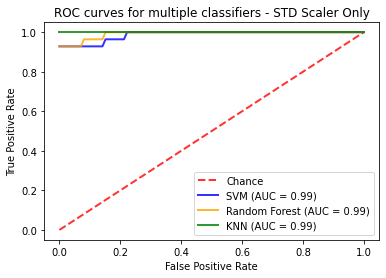

In [41]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
plt.plot(mean_fpr, SVM_tpr_std[0,:], lw=2, color='blue', label='SVM (AUC = %0.2f)' % (SVM_auc), alpha=0.8)
plt.plot(mean_fpr, RF_tpr_std[0,:], lw=2, color='orange', label='Random Forest (AUC = %0.2f)' % (RF_auc), alpha=0.8)
plt.plot(mean_fpr, KNN_tpr_std[0,:], lw=2, color='green', label='KNN (AUC = %0.2f)' % (RF_auc), alpha=0.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for multiple classifiers - STD Scaler Only')
plt.legend(loc="lower right")
plt.show()

### Compare the ROC curves against each other

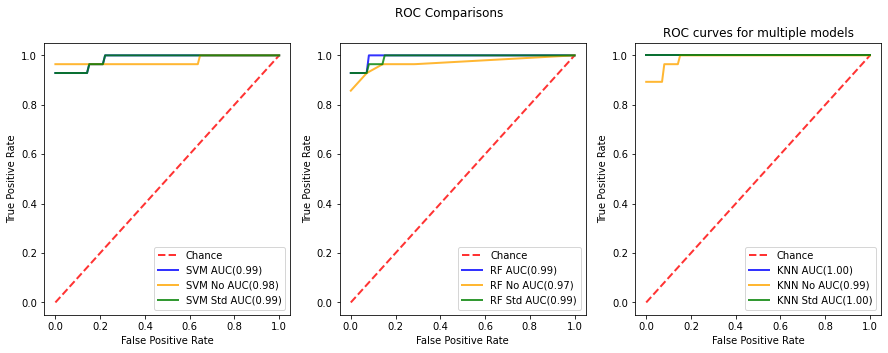

In [42]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
fig.suptitle('ROC Comparisons')

ax1.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
ax1.plot(mean_fpr, SVM_tpr[0,:], lw=2, color='blue', label='SVM AUC(%0.2f)' % (SVM_auc) , alpha=0.8)
ax1.plot(mean_fpr, SVM_tpr_no[0,:], lw=2, color='orange', label='SVM No AUC(%0.2f)' % (SVM_auc_no) , alpha=0.8)
ax1.plot(mean_fpr, SVM_tpr_std[0,:], lw=2, color='green', label='SVM Std AUC(%0.2f)' % (SVM_auc_std) , alpha=0.8)
ax1.set(xlabel="False Positive Rate", ylabel="True Positive Rate")
ax1.title.set_text('')
ax1.legend(loc="lower right")

ax2.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
ax2.plot(mean_fpr, RF_tpr[0,:], lw=2, color='blue', label='RF AUC(%0.2f)' % (RF_auc) , alpha=0.8)
ax2.plot(mean_fpr, RF_tpr_no[0,:], lw=2, color='orange', label='RF No AUC(%0.2f)' % (RF_auc_no) , alpha=0.8)
ax2.plot(mean_fpr, RF_tpr_std[0,:], lw=2, color='green', label='RF Std AUC(%0.2f)' % (RF_auc_std) , alpha=0.8)
ax2.set(xlabel="False Positive Rate", ylabel="True Positive Rate")
ax2.title.set_text('')
ax2.legend(loc="lower right")

ax3.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
ax3.plot(mean_fpr, KNN_tpr[0,:], lw=2, color='blue', label='KNN AUC(%0.2f)' % (KNN_auc) , alpha=0.8)
ax3.plot(mean_fpr, KNN_tpr_no[0,:], lw=2, color='orange', label='KNN No AUC(%0.2f)' % (KNN_auc_no) , alpha=0.8)
ax3.plot(mean_fpr, KNN_tpr_std[0,:], lw=2, color='green', label='KNN Std AUC(%0.2f)' % (KNN_auc_std) , alpha=0.8)
ax3.set(xlabel="False Positive Rate", ylabel="True Positive Rate")
ax3.title.set_text('')
ax3.legend(loc="lower right")
plt.title('ROC curves for multiple models')

plt.show()

Plot Precision Recall Curves



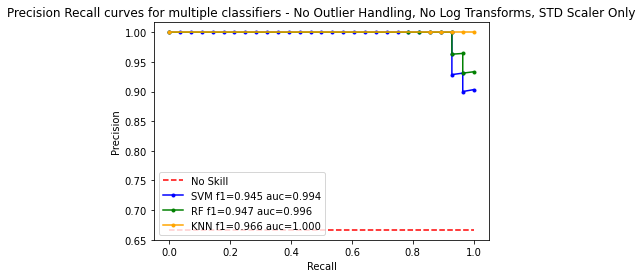

In [43]:
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', color='red', label='No Skill')
plt.plot(SVM_pr_recall_std, SVM_pr_precision_std, marker='.', color='blue', label='SVM f1=%.3f auc=%.3f' % (SVM_pr_f1_std, SVM_pr_auc_std))
plt.plot(RF_pr_recall_std, RF_pr_precision_std, marker='.', color='green', label='RF f1=%.3f auc=%.3f' % (RF_pr_f1_std, RF_pr_auc_std))
plt.plot(KNN_pr_recall_std, KNN_pr_precision_std, marker='.', color='orange', label='KNN f1=%.3f auc=%.3f' % (KNN_pr_f1_std, KNN_pr_auc_std))
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.title('Precision Recall curves for multiple classifiers - No Outlier Handling, No Log Transforms, STD Scaler Only')
plt.legend(loc="lower left")
# show the plot
plt.show()

#### Graph Precision Recall Curves for various models side by side

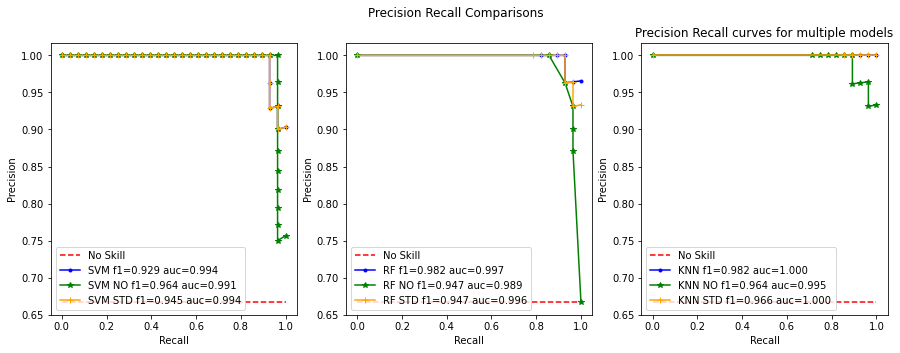

In [44]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
fig.suptitle('Precision Recall Comparisons')

no_skill = len(y_test[y_test==1]) / len(y_test)
ax1.plot([0, 1], [no_skill, no_skill], linestyle='--', color='red', label='No Skill')
ax1.plot(SVM_pr_recall, SVM_pr_precision, marker='.', color='blue', label='SVM f1=%.3f auc=%.3f' % (SVM_pr_f1, SVM_pr_auc))
ax1.plot(SVM_pr_recall_no, SVM_pr_precision_no, marker='*', color='green', label='SVM NO f1=%.3f auc=%.3f' % (SVM_pr_f1_no, SVM_pr_auc_no))
ax1.plot(SVM_pr_recall_std, SVM_pr_precision_std, marker='+', color='orange', label='SVM STD f1=%.3f auc=%.3f' % (SVM_pr_f1_std, SVM_pr_auc_std))
ax1.set(xlabel="Recall", ylabel="Precision")
ax1.title.set_text('')
ax1.legend(loc="lower left")

ax2.plot([0, 1], [no_skill, no_skill], linestyle='--', color='red', label='No Skill')
ax2.plot(RF_pr_recall, RF_pr_precision, marker='.', color='blue', label='RF f1=%.3f auc=%.3f' % (RF_pr_f1, RF_pr_auc))
ax2.plot(RF_pr_recall_no, RF_pr_precision_no, marker='*', color='green', label='RF NO f1=%.3f auc=%.3f' % (RF_pr_f1_no, RF_pr_auc_no))
ax2.plot(RF_pr_recall_std, RF_pr_precision_std, marker='+', color='orange', label='RF STD f1=%.3f auc=%.3f' % (RF_pr_f1_std, RF_pr_auc_std))
ax2.set(xlabel="Recall", ylabel="Precision")
ax2.title.set_text('')
ax2.legend(loc="lower left")

ax3.plot([0, 1], [no_skill, no_skill], linestyle='--', color='red', label='No Skill')
ax3.plot(KNN_pr_recall, KNN_pr_precision, marker='.', color='blue', label='KNN f1=%.3f auc=%.3f' % (KNN_pr_f1, KNN_pr_auc))
ax3.plot(KNN_pr_recall_no, KNN_pr_precision_no, marker='*', color='green', label='KNN NO f1=%.3f auc=%.3f' % (KNN_pr_f1_no, KNN_pr_auc_no))
ax3.plot(KNN_pr_recall_std, KNN_pr_precision_std, marker='+', color='orange', label='KNN STD f1=%.3f auc=%.3f' % (KNN_pr_f1_std, KNN_pr_auc_std))
ax3.set(xlabel="Recall", ylabel="Precision")
ax3.title.set_text('')
ax3.legend(loc="lower left")
plt.title('Precision Recall curves for multiple models')

plt.show()

## TASK 3 CONCLUSION

I added KNN classification and explored different data preparation approaches. I selected the best parameters using a grid search.  

Data analysis approaches:   
- 1 column log-transformed and RobustScaled, 1 column sqrt-transformed, the rest StandardScaled.  
- 1 column sqrt-transformed, all columns StandardScaled.   
- All columns StandardScaled  
    
The results were graphed on ROC and Precision-Recall charts.  

The ROC graphs do not assist much, which is expected given the imbalance between the Yes (66%) and No (33%).  

From the Precision Recall graphs I determine:  
- SVM performs best when the transforms and RobustScaler are applied.  
- RF performed best when the data was transformed and RobustScaled and much worse on the data with no RobustScaling.  
- **KNN performed best of the three** and performs best where the transforms and RobustScaler are applied.  

**Conclusion**: The Classifiers all performed best with different approaches. It is worth tuning the data carefully!      